In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder # for pipeline
from sklearn.base import BaseEstimator, TransformerMixin # for pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt



In [4]:
raw_data = pd.read_csv(r"Housing.csv")

# **Inspect Our Data**

In [5]:
raw_data.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [6]:
# We dont have null values
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


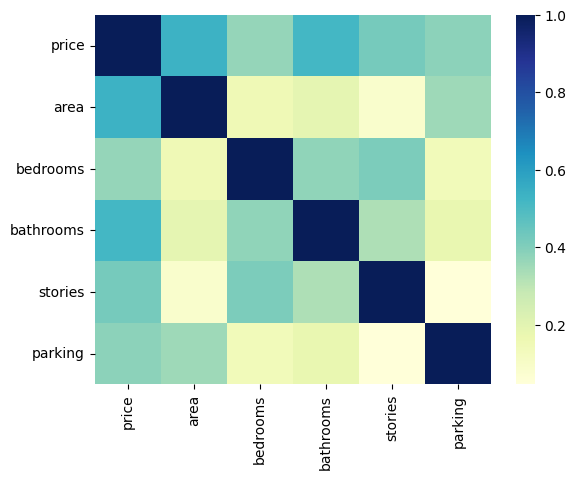

In [7]:
#Check correlation, we have multicolonearity
processed_data = raw_data.copy()
sns.heatmap(processed_data.corr(numeric_only=True), cmap='YlGnBu')
plt.show()

In [8]:
processed_data.columns

Index(['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'mainroad',
       'guestroom', 'basement', 'hotwaterheating', 'airconditioning',
       'parking', 'prefarea', 'furnishingstatus'],
      dtype='object')

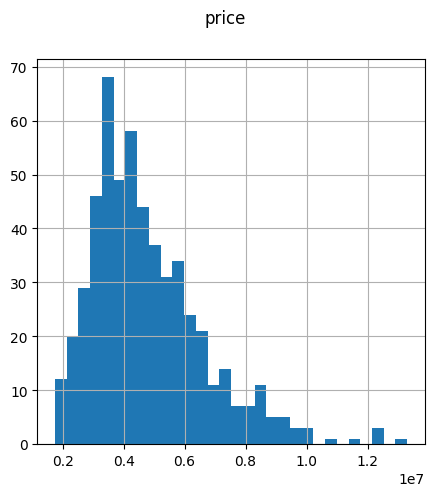

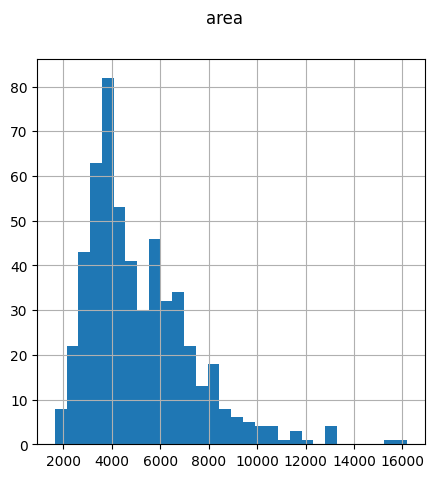

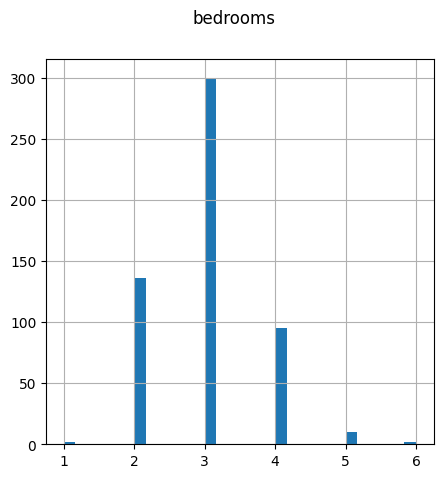

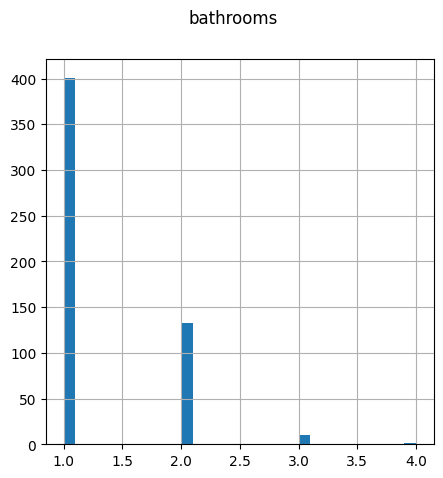

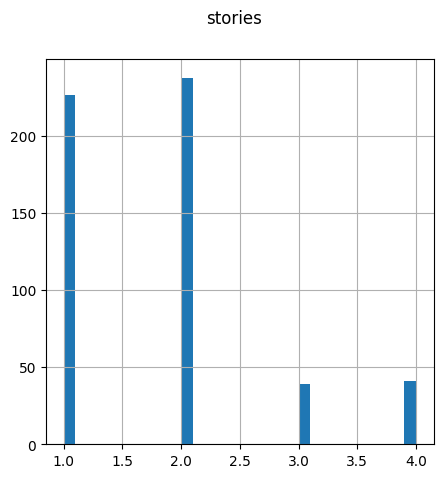

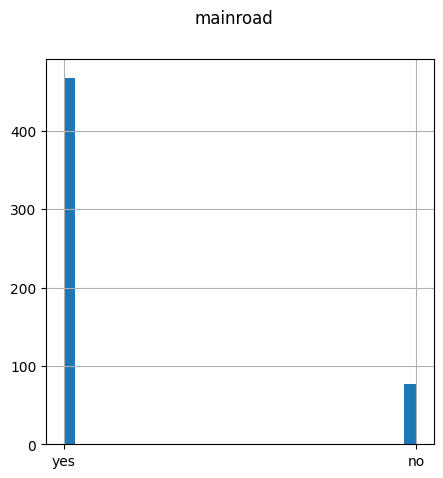

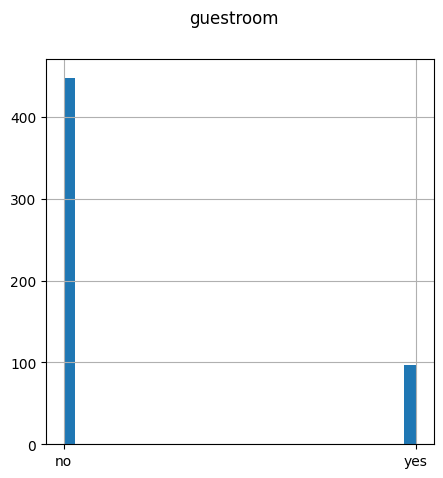

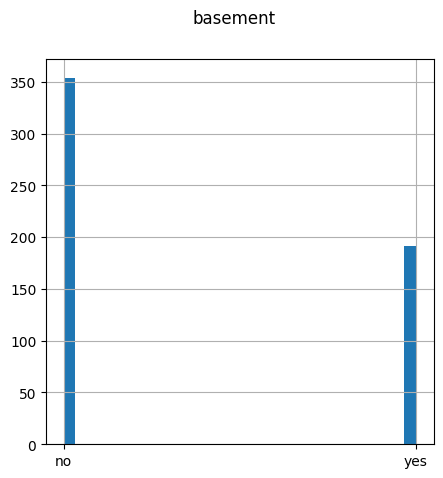

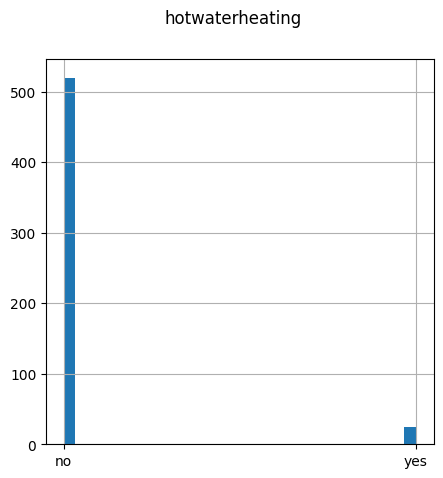

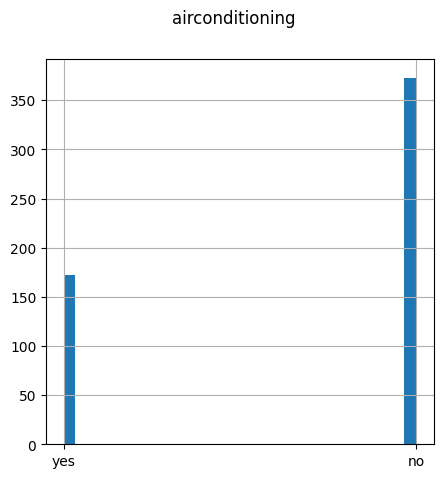

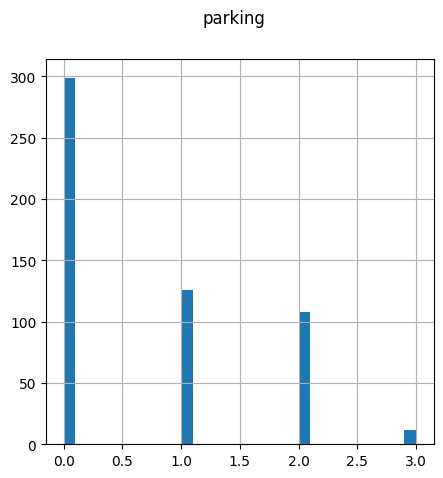

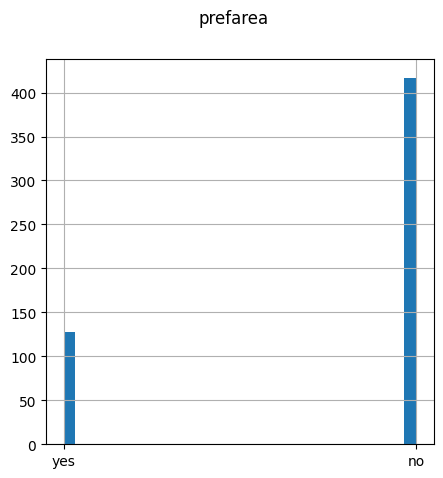

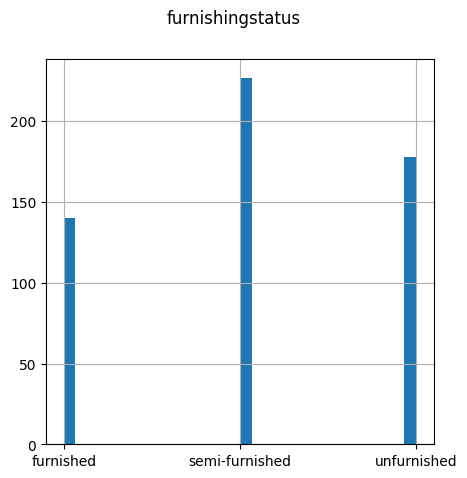

In [9]:
for i in processed_data.columns:
    processed_data[i].hist(bins=30, figsize=(5,5))
    plt.suptitle(i)
    plt.show()

# **Normalize Our Data**

In [10]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    features_to_encode = ['guestroom', 'mainroad','basement','hotwaterheating',
                          'airconditioning','prefarea']
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy() 
        for feature in self.features_to_encode:
            if feature in X.columns:
                X[feature] = X[feature].map({'yes': 1, 'no': 0})
        return X
        
class CategoricalFeatEncoder(BaseEstimator, TransformerMixin):
    features_to_encode = ['furnishingstatus']

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X = X.copy()
        for feature in self.features_to_encode:
            if feature in X.columns:
               dummy_col = pd.get_dummies(X['furnishingstatus'])
        X = pd.concat([X, dummy_col], axis=1)

        return X

class FeatureScaler(BaseEstimator, TransformerMixin):
    col_to_scale = ['area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'price']

    def fit(self, X, y=None):
        self.scaler = StandardScaler()
        return self
    
    def transform(self, X):
        X = X.copy()
        for feature in self.col_to_scale:
            if feature in X.columns:
                X[feature] = self.scaler.fit_transform(X[[feature]])
        return X

In [11]:
pipeline = Pipeline(
    [('featureencoder',FeatureEncoder()),
     ('categoricalfeatEncoder',CategoricalFeatEncoder()),
     ('featurescaler',FeatureScaler())
    ]
    )

In [12]:
processed_data = pipeline.fit_transform(processed_data)

In [13]:
# Reorder columns
new_columns = [
    'area',
    'bedrooms',
    'bathrooms',
    'stories',
    'mainroad',
    'guestroom', 
    'basement', 
    'hotwaterheating', 
    'airconditioning',
    'parking', 
    'prefarea', 
    'furnished',
    'semi-furnished',
    'unfurnished',
    'price'
]
processed_data = processed_data[new_columns]
processed_data.head(10)

,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnished,semi-furnished,unfurnished,price
0,1.046726,1.403419,1.421812,1.378217,1,0,0,0,1,1.517692,1,True,False,False,4.566365
1,1.757010,1.403419,5.405809,2.532024,1,0,0,0,1,2.679409,0,True,False,False,4.004484
2,2.218232,0.047278,1.421812,0.224410,1,0,1,0,0,1.517692,1,False,True,False,4.004484
3,1.083624,1.403419,1.421812,0.224410,1,0,1,0,1,2.679409,1,True,False,False,3.985755
4,1.046726,1.403419,-0.570187,0.224410,1,1,1,0,1,1.517692,0,True,False,False,3.554979
5,1.083624,0.047278,3.413810,-0.929397,1,0,1,0,1,1.517692,1,False,True,False,3.255309
6,1.581745,1.403419,3.413810,2.532024,1,0,0,0,1,1.517692,1,False,True,False,2.880722
7,5.096263,2.759560,3.413810,0.224410,1,0,0,0,0,-0.805741,0,False,False,True,2.880722
8,1.360358,1.403419,-0.570187,0.224410,1,1,1,0,1,1.517692,1,True,False,False,2.730887
9,0.276484,0.047278,1.421812,2.532024,1,1,0,0,1,0.355976,1,False,False,True,2.693428


# **Select Model**

In [19]:
X = processed_data.values[:,0:13]
y = processed_data.values[:,13]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

LinearRegression()

In [21]:
y_train_pred = lin_reg.predict(X_train)

In [22]:
mse = mean_squared_error(y_train, y_train_pred)
r2 = r2_score(y_train, y_train_pred)
print(f"Mean Squared Error on Training Data: {mse}")
print(f"R-squared on Training Data: {r2}")



Mean Squared Error on Training Data: 1.599829365913742e-31
R-squared on Training Data: 1.0


In [23]:
import pickle
filename = 'housing_model.pkl'
with open(filename, 'wb') as file:
    pickle.dump(lin_reg, file)